In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
from src.settings import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
from src.tools.aggregation import aggregate_hex
import json5 as json
tqdm.pandas()

In [3]:
with open(RAW_DATA_DIR / "featureset_default.jsonc", "r") as f:
    FEATURESET = json.load(f)

In [4]:
cities = pd.read_csv(RAW_DATA_DIR / "cities.csv")
# cities = cities[(cities.country == "Poland") & (cities.kacper)]
cities

,city,country,kacper,szymon,piotr,kamil,regions
0,Tirana,Albania,False,True,False,False,NaN
1,Yerevan,Armenia,False,True,False,False,NaN
2,Sydney,Australia,True,False,False,False,NaN
3,Vienna,Austria,False,True,True,True,NaN
4,Baku,Azerbaijan,False,True,False,False,NaN
...,...,...,...,...,...,...,...
112,Los Angeles,United States,True,True,False,False,NaN
113,New York City,United States,True,True,False,False,NaN
114,Philadelphia,United States,False,True,False,False,NaN
115,San Francisco,United States,True,True,False,False,NaN


In [5]:
resolution = 9
buffered = True
network_type = "drive"

pbar = tqdm(cities.itertuples(), total=cities.shape[0])
hexagons = []
edges = []
for row in pbar:
    place_name = f"{row.city},{row.country}"
    place_dir_name = get_place_dir_name(place_name)
    place_dir_path = GENERATED_DATA_DIR / place_dir_name
    gpkg_path = place_dir_path / f"graph_{network_type}.gpkg"
    pbar.set_description(place_name)

    try:
        hexagons_city = gpd.read_file(gpkg_path, layer=f"hex_{get_resolution_buffered_suffix(resolution, buffered)}")
        hexagons_city["city"] = row.city
        hexagons_city["country"] = row.country
        hexagons.append(hexagons_city)

        edges_city = gpd.read_feather(place_dir_path / f"edges_{network_type}_{get_resolution_buffered_suffix(resolution, buffered)}.feather")
        edges_city["city"] = row.city
        edges_city["country"] = row.country
        edges.append(edges_city)
    except Exception as e:
        print("\nFailed", place_name, e)
    

hexagons = pd.concat(hexagons, ignore_index=True).set_index("h3_id")
edges = pd.concat(edges, ignore_index=True)
hex_agg = aggregate_hex(edges.drop(columns=["city", "country"]))


del hexagons_city
del edges_city

Washington D.C.,United States: 100%|██████████| 117/117 [02:24<00:00,  1.24s/it]


In [6]:
edges

,u,v,key,id,h3_id,geometry,oneway_True,lanes_1,lanes_2,lanes_3,...,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector,city,country
0,15459891,15494062,0,0,891ed4004dbffff,"LINESTRING (19.81635 41.31964, 19.81637 41.319...",1,0,1,0,...,0,0,0,0,0,0,0,0,Tirana,Albania
1,15459891,1840198326,0,1,891ed4004dbffff,"LINESTRING (19.81635 41.31964, 19.81642 41.319...",1,1,0,0,...,0,0,0,0,0,0,0,0,Tirana,Albania
2,15459891,1867590632,0,2,891ed4004dbffff,"LINESTRING (19.81611 41.32051, 19.81613 41.320...",1,0,1,0,...,0,0,0,0,0,0,0,0,Tirana,Albania
3,15459891,3524348462,0,3,891ed4004dbffff,"LINESTRING (19.81566 41.31953, 19.81605 41.319...",1,1,0,0,...,0,0,0,0,0,0,0,0,Tirana,Albania
4,15460178,1843574977,0,4,891ed4031abffff,"LINESTRING (19.80814 41.31982, 19.80832 41.319...",1,1,0,0,...,0,0,0,0,0,0,0,0,Tirana,Albania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954142,9136682496,9136682512,0,16296,892aa845e63ffff,"LINESTRING (-77.03029 38.90982, -77.03036 38.9...",1,1,0,0,...,0,0,0,0,0,0,0,0,Washington D.C.,United States
3954143,9154700293,9154700294,0,16297,892aa8458abffff,"LINESTRING (-76.99722 38.89456, -76.99717 38.8...",0,0,0,0,...,0,0,0,0,0,0,0,0,Washington D.C.,United States
3954144,9154700293,9154700294,0,16297,892aa8458afffff,"LINESTRING (-76.99722 38.89456, -76.99717 38.8...",0,0,0,0,...,0,0,0,0,0,0,0,0,Washington D.C.,United States
3954145,9166612486,9166612487,0,16298,892aa845ad3ffff,"LINESTRING (-77.03634 38.90746, -77.03638 38.9...",1,0,0,1,...,0,0,0,0,0,0,0,0,Washington D.C.,United States


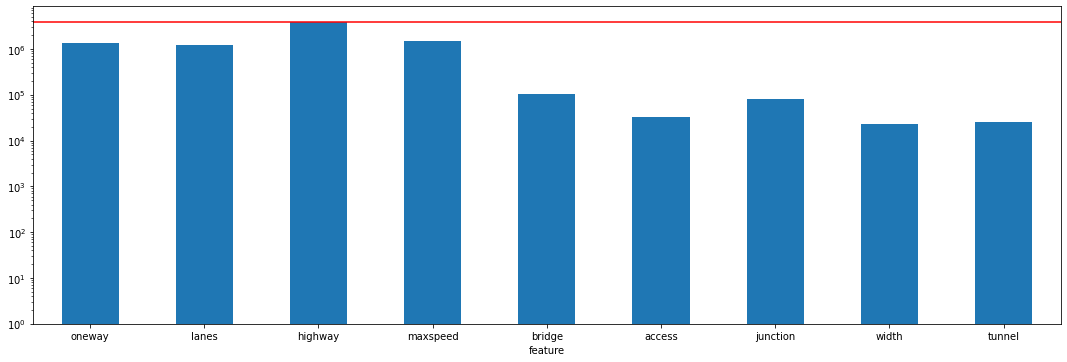

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
counts = []
plt.tight_layout()
for i, feature in enumerate(FEATURESET.keys()):
    columns = [x for x in edges.columns if feature in x]
    counts.append(edges[columns].sum().sum())
df_to_plot = pd.DataFrame(data={"feature": list(FEATURESET.keys()), "count": counts }).set_index("feature")
df_to_plot.plot(kind="bar", ax=ax, title="", rot=0, legend=False, xlabel="feature", log=True)
ax.axes.axhline(len(edges.index), color="red")
plt.show()

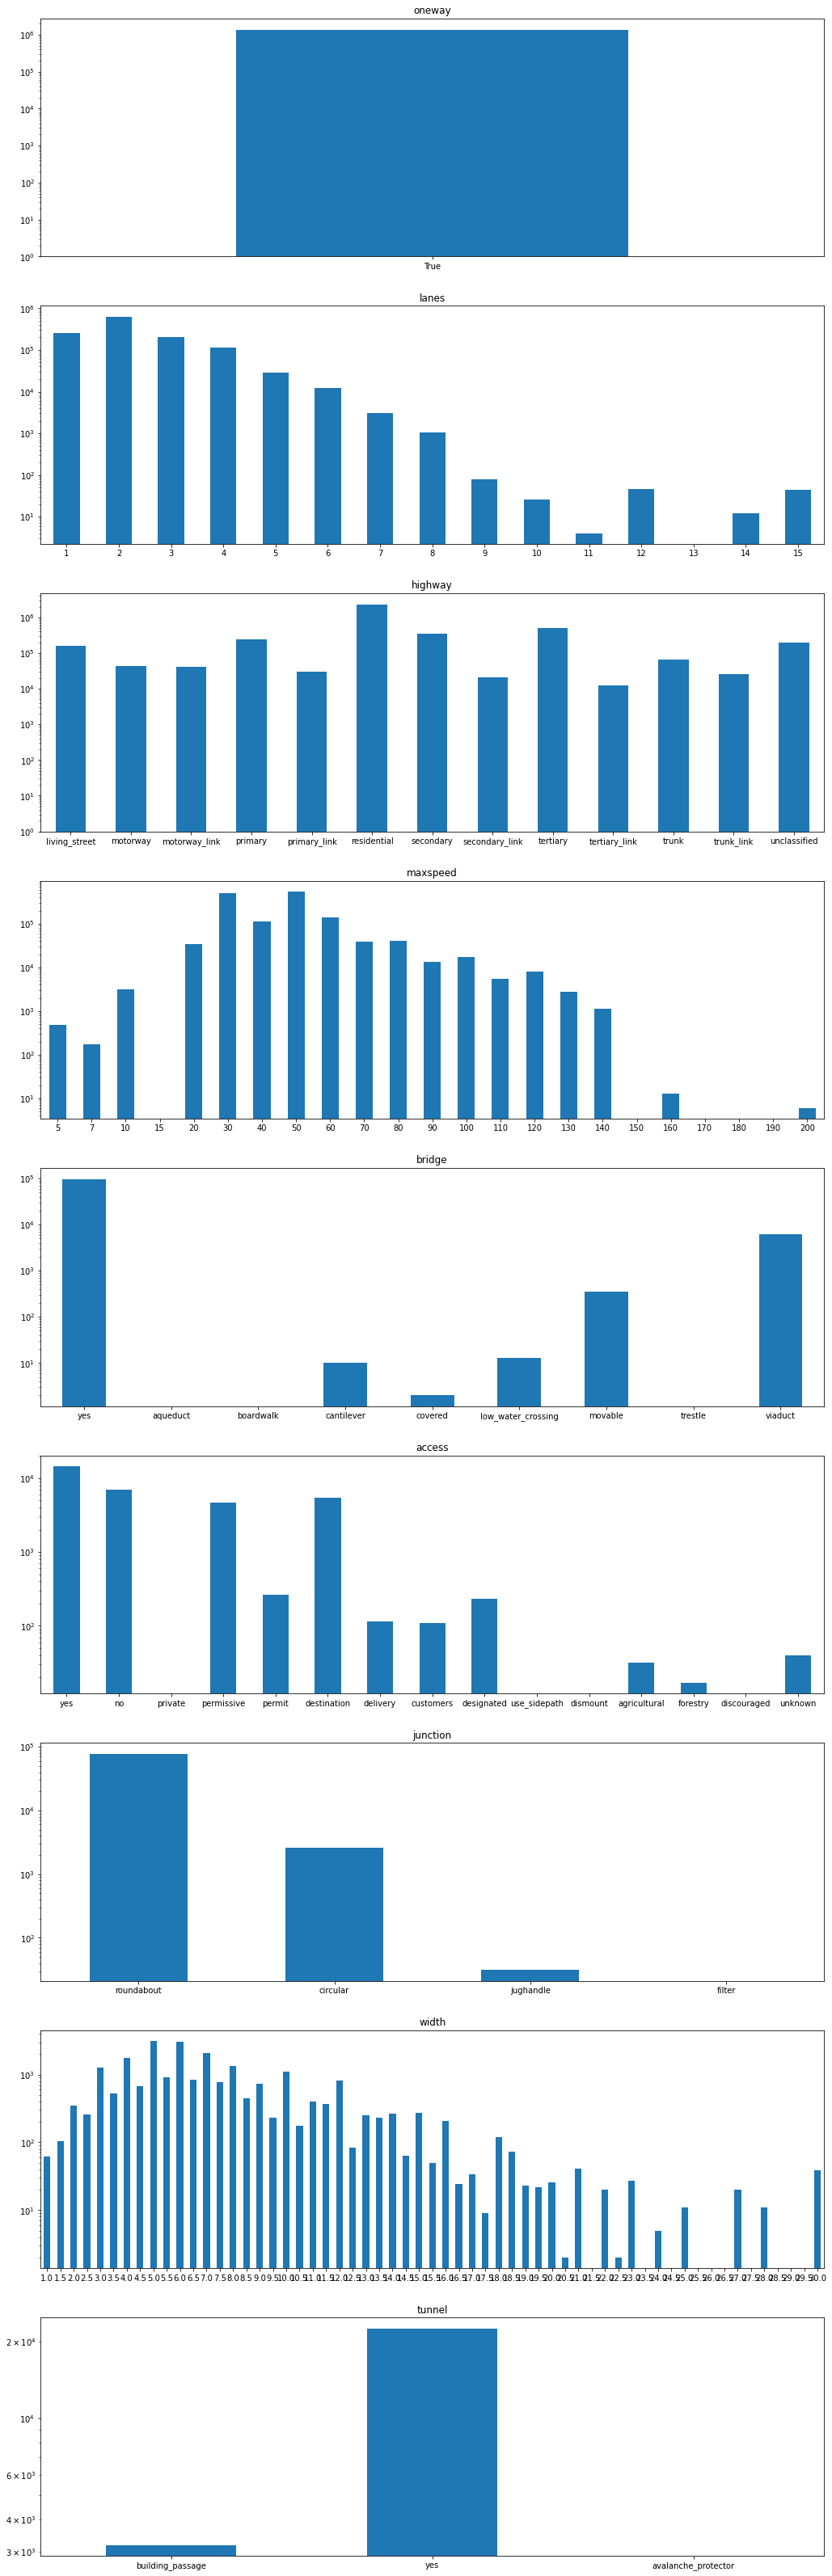

In [8]:
n = len(FEATURESET)

fig, axs = plt.subplots(n, figsize=(15, 5 * n))
plt.tight_layout(pad=4)
for i, feature in enumerate(FEATURESET.keys()):
    columns = [x for x in edges.columns if feature in x]
    if feature == "width":
        columns.sort(key=lambda x: float(x.split("_")[1]))
    df_to_plot = edges[columns].rename(columns={column: "_".join(column.split("_")[1:]) for column in columns}).sum()
    # df_to_plot["None"] = len(edges.index) - df_to_plot.sum()
    df_to_plot.plot(kind="bar", ax=axs[i], title=feature, rot=0, log=True)
plt.show()

In [9]:
from src.tools.feature_extraction import melt_and_max

df_agg = edges.copy()
for column_name in ["oneway", "lanes", "maxspeed", "width"]:
    columns = [x for x in edges.columns if column_name in x]
    df_agg = df_agg.join(melt_and_max(edges, column_name, columns), on="id")
df_agg = df_agg.set_crs(epsg=4326)

ValueError: could not convert string to float: 'True'

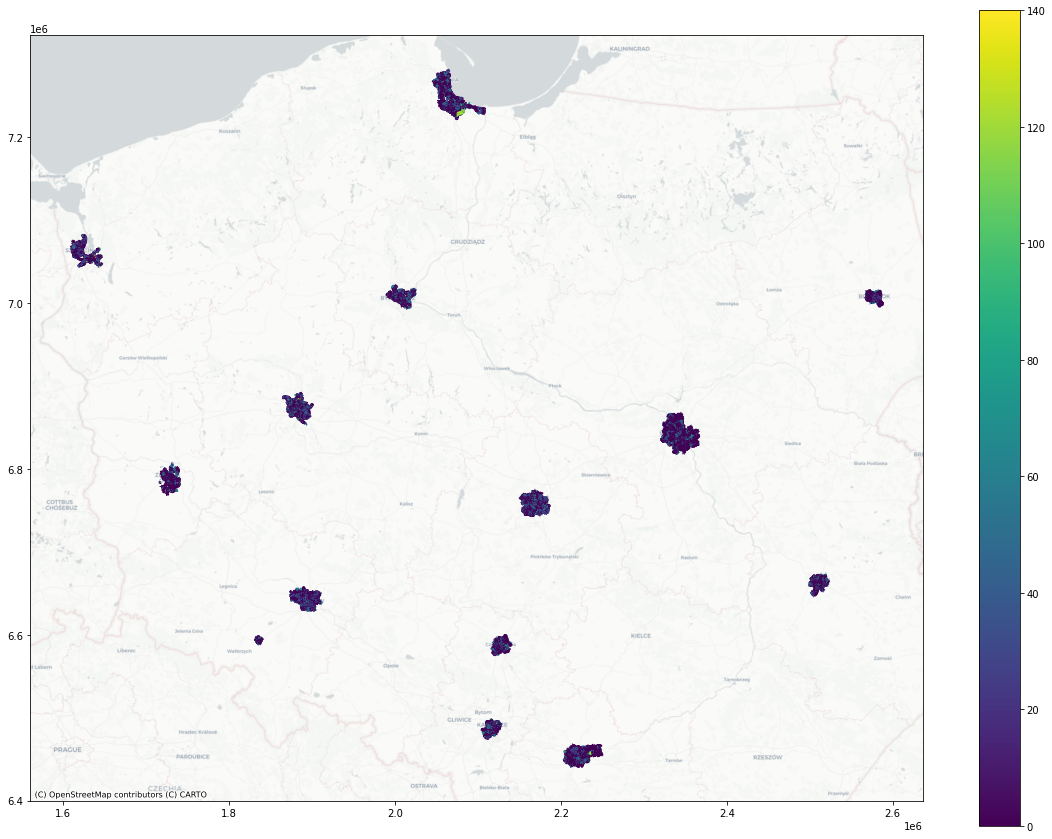

In [ ]:
column_name = "maxspeed"

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.set_aspect('equal')
df_agg.to_crs(epsg=3857).plot(ax=ax, column=column_name, alpha=1, legend=True, linewidth=3)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)